In [3]:
import models as M
import data as D

import torch

import torch.nn as nn


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

encoder = M.Encoder()
decoder = M.Decoder()
model = M.Autoencoder_conv(encoder, decoder).to(device)
#model = M.Autoencoder_MLP().to(device)


trainset =  D.BaxterJointsSynthDataset("./data/dataset", [0], "train", demo = False, img_size=None, sequence_length=1, norm_type="min_max")
trainset.train()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                        shuffle=False, num_workers=1,
                                        worker_init_fn=D.init_worker, drop_last=True)


Loading val set run 0: 100%|██████████| 1908/1908 [00:00<00:00, 109524.44it/s]


In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.actv = nn.LeakyReLU(0.2)

        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.actv(x)
        x = self.conv2(x)
        x = self.actv(x)

        return x
    
class ConvTranspBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super().__init__()
        self.conv_tr1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.conv_tr2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, padding=1, stride=stride)
        self.actv = nn.LeakyReLU(0.2)


        torch.nn.init.kaiming_normal_(self.conv_tr1.weight)
        torch.nn.init.kaiming_normal_(self.conv_tr2.weight)

    
    def forward(self, x):
        x = self.actv(x)
        x = self.conv_tr1(x)
        x = self.actv(x)
        x = self.conv_tr2(x)

        return x
    
#Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        #For the first convolution, we have input channels = 1. 32 and 3 are chosen arbitrarly for now
        self.conv1 = ConvBlock(1*1, 32, 3)#The input channels depend on the sequence length chosen
        self.conv2 = ConvBlock(32, 64, 3)

        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x
        
#Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_tr1 = ConvTranspBlock(64, 32, 3)
        self.conv_tr2 = ConvTranspBlock(32, 1, 3)#TOCHECK The out_channels is at 1 because we have to produce an image; at this stage 
                                            # it can be the last frame or the next one
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        
    def forward(self, x):
        x = self.upsample(x)

        x = self.conv_tr1(x)
        x = self.conv_tr2(x)

        return x

#Autoencoder
class Autoencoder_conv(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder

    def encode(self, input_sequence):
        return self.enc(input_sequence)
    
    def decode(self, latent_vector):
        return self.dec(latent_vector)
    
    def forward(self, input_sequence):
        x = self.encode(input_sequence)

        y = x.clone()
   
        out = self.decode(x)
        #Added the ReLU activation to have only positive values in the output
        #as we are dealing with the depth values
        return out, y#latent_vector

In [2]:
sum(p.numel() for p in model.parameters())

29000917

In [19]:
encoder = Encoder()
decoder = Decoder()
model = Autoencoder_conv(encoder, decoder).to(device)

In [4]:
out_list = []
gt_list = []

for images in trainloader:
    images = images["depth8"].to(device)
    #images = images.squeeze()#FIXME added to unify channels and sequence length; to sub it for reshape
    #images.shape: [batch_size, sequence_length, channels, height, width]
    images = images.reshape((images.shape[0], images.shape[1]*images.shape[2], images.shape[3], images.shape[4] ))#----> NOT NEEDED FOR 3D CONVOLUTIONS

    out, latent = model(images)

    out_list.append(out)
    gt_list.append(images)

    break



In [5]:
print(
        out_list[0].min(),
        gt_list[0].min(),
        out_list[0].max(),
        gt_list[0].max(),
)


tensor(-0.3447, device='cuda:0', grad_fn=<MinBackward1>) tensor(0., device='cuda:0') tensor(0.3398, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1., device='cuda:0')


In [5]:
out_list[0].shape

torch.Size([1, 1, 432, 768])

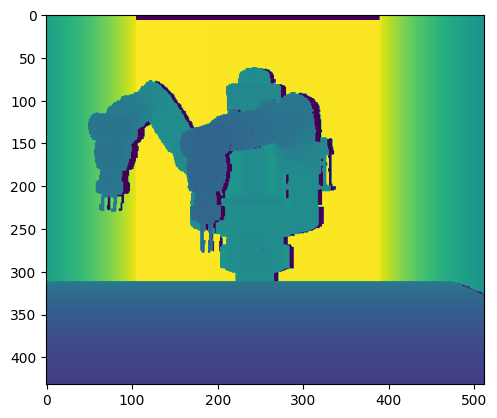

In [6]:
import matplotlib.pyplot as plt

img = gt_list[0][0][0].detach().cpu().numpy()
plt.imshow(img)

In [7]:
img

array([[145., 145., 147., ..., 133., 132., 131.],
       [145., 145., 147., ..., 133., 132., 131.],
       [145., 145., 147., ..., 133., 132., 131.],
       ...,
       [ 48.,  48.,  48., ...,  48.,  48.,  48.],
       [ 47.,  47.,  47., ...,  47.,  47.,  47.],
       [ 47.,  47.,  47., ...,  47.,  47.,  47.]], dtype=float32)

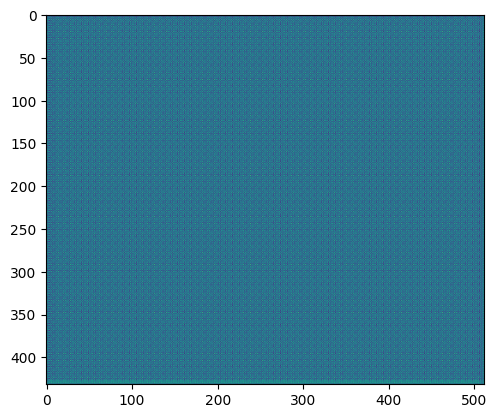

In [7]:
img = out_list[0][0][0].detach().cpu().numpy()
plt.imshow(img)

In [7]:
img

array([[ 0.05334469, -0.0151935 , -0.02521812, ..., -0.02949145,
        -0.00477272,  0.04372576],
       [ 0.07259515,  0.02056538,  0.00987471, ...,  0.0096863 ,
         0.02295946,  0.06360341],
       [ 0.07394584,  0.01408972,  0.00790795, ...,  0.00829762,
         0.01810636,  0.06461072],
       ...,
       [ 0.06903184,  0.00345504, -0.00753769, ..., -0.00338948,
         0.00523467,  0.06056726],
       [ 0.07456627,  0.00613252,  0.00417895, ...,  0.0077489 ,
         0.01152205,  0.06872229],
       [ 0.11025435,  0.08861827,  0.09205077, ...,  0.08982238,
         0.08838344,  0.09596151]], dtype=float32)

torch.Size([1, 64, 124, 124])


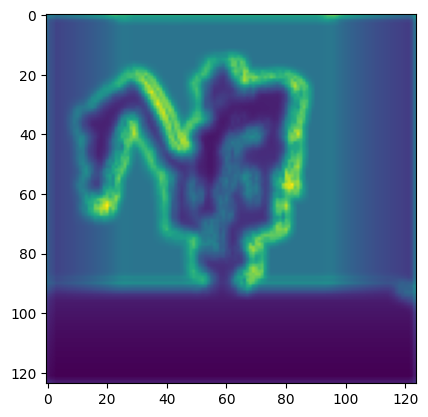

In [16]:
print(latent.shape)

plt.imshow(torch.mean(latent.squeeze(), dim=0).squeeze().cpu().detach().numpy())
plt.show()